In [175]:
import torch
from torch import nn
import copy
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
from teaching import Mario

In [176]:
%config InlineBackend.figure_format = "retina"

In [207]:
class Environment(gym.Env):

    def __init__(self, n_item=30, t_max=1000):
        super().__init__()
        self.action_space = spaces.Discrete(n_item)
        self.state = torch.zeros((n_item, 2))
        self.n_item = n_item
        self.t_max = t_max
        self.t = 0
        self.log_tau = np.log(0.9)

    def reset(self):
        self.state = torch.zeros((self.n_item, 2))
        self.t = 0
        return self.state.flatten()

    def step(self, action):
        self.state[:, 0] += 1
        self.state[action, 0] = 0
        self.state[action, 1] += 1
        view = self.state[:, 1] > 0
        logp_recall = - self.state[view, 0]*0.8**(self.state[view, 1] - 1)
        # print("logp", logp_recall)
        above_thr = logp_recall > self.log_tau
        # print(torch.count_nonzero(above_thr))
        reward = torch.count_nonzero(above_thr).item()
        next_state = self.state.flatten()
        done = self.t == self.t_max - 1
        self.t += 1
        info = {'n view': torch.count_nonzero(view).item(), 'reward': reward}
        return next_state, reward, done, info

    def render(self, mode='human'):
        pass

In [208]:
class Threshold:
    def __init__(self):
        pass
    def act(self, env):
        state = env.state
        view = env.state[:, 1] > 0
        logp_recall = - env.state[view, 0]*0.8**(env.state[view, 1] - 1)
        # print("logp", logp_recall)
        under_thr = logp_recall <= env.log_tau
        if torch.count_nonzero(under_thr).item() > 0:
            items = torch.arange(env.n_item)
            viewed = items[view]
            action = viewed[torch.argmin(logp_recall)].item()
        else:
            n_seen = torch.count_nonzero(view).item()
            max_item = env.n_item-1
            action = np.min((n_seen, max_item))

        return action

In [209]:
env = Environment()
state = env.reset()
policy = Threshold()
rewards = []
actions = []
while True:
    action = policy.act(env)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

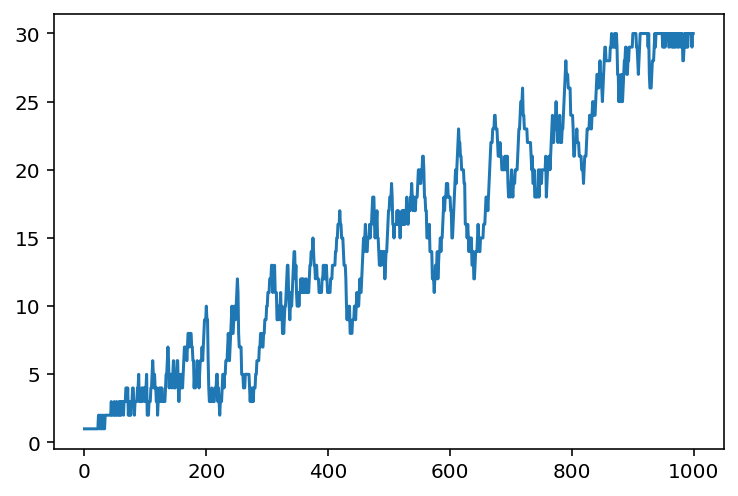

In [210]:
plt.plot(rewards)

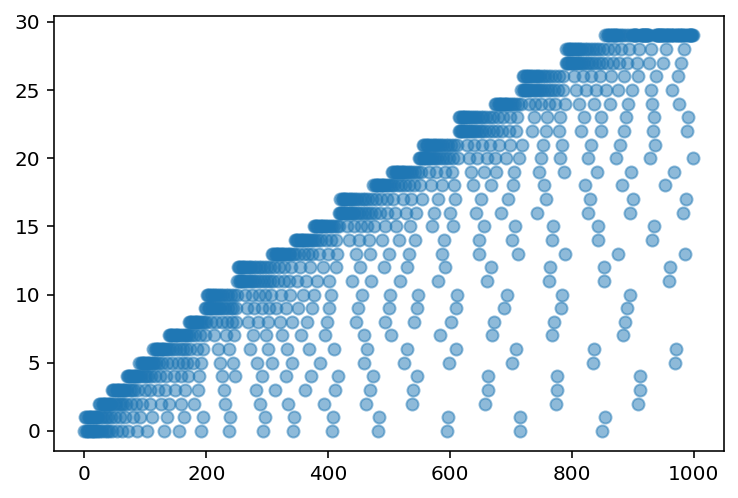

In [214]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5)

In [215]:
env = Environment()
state = env.reset()
rewards = []
actions = []
while True:
    action = np.random.randint(env.n_item)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

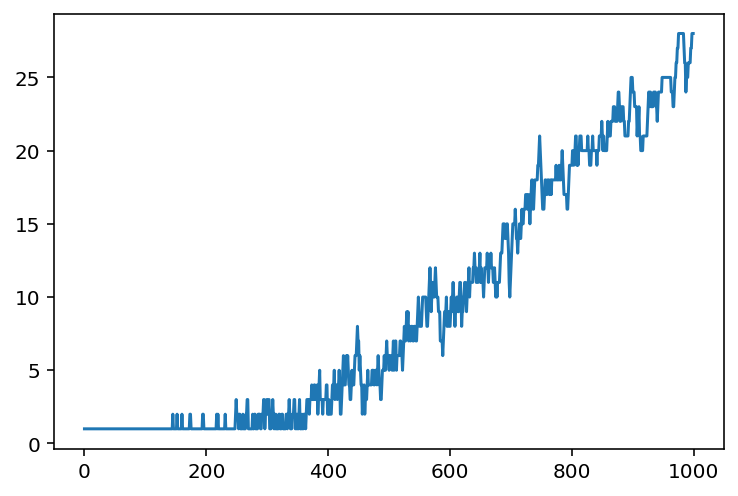

In [216]:
plt.plot(rewards)

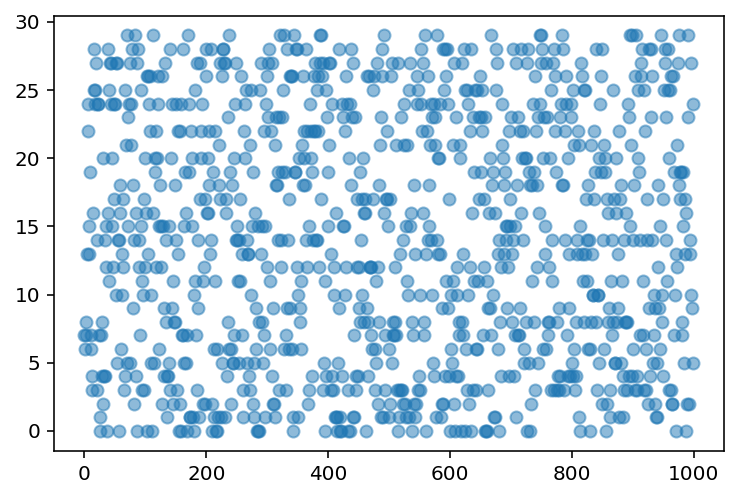

In [217]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5)

In [256]:
bkp = torch.load("checkpoints/2021-05-03T18-45-15/mario_net_11.chkpt")
mario = Mario(state_dim=env.n_item*2, action_dim=env.action_space.n, save_dir=None)
mario.net.load_state_dict(bkp['model'])
mario.net.eval()

<All keys matched successfully>

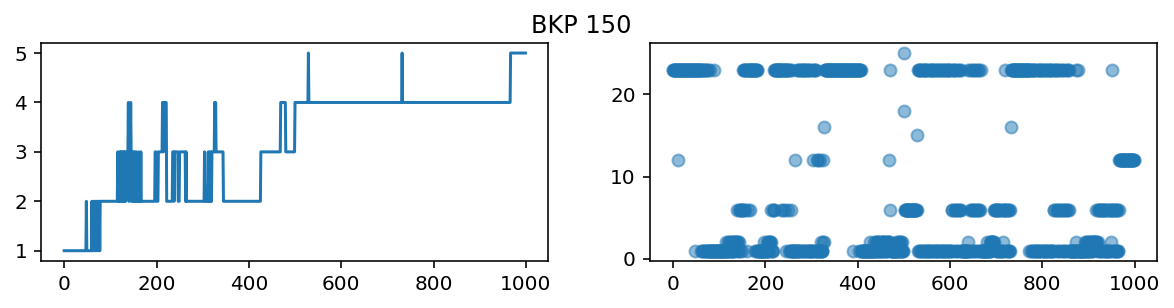

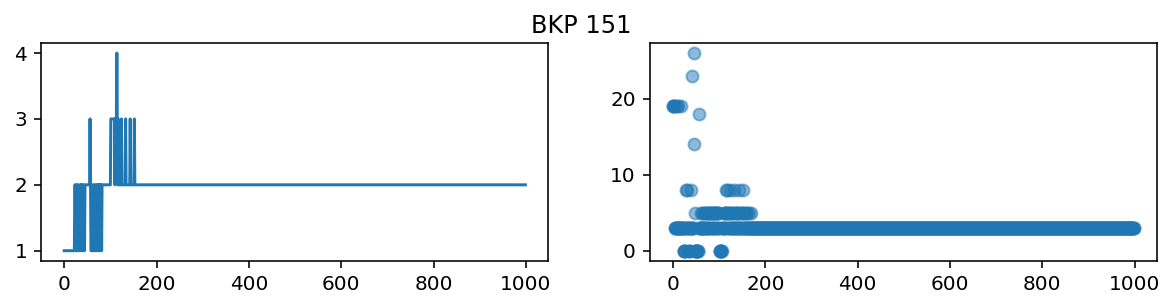

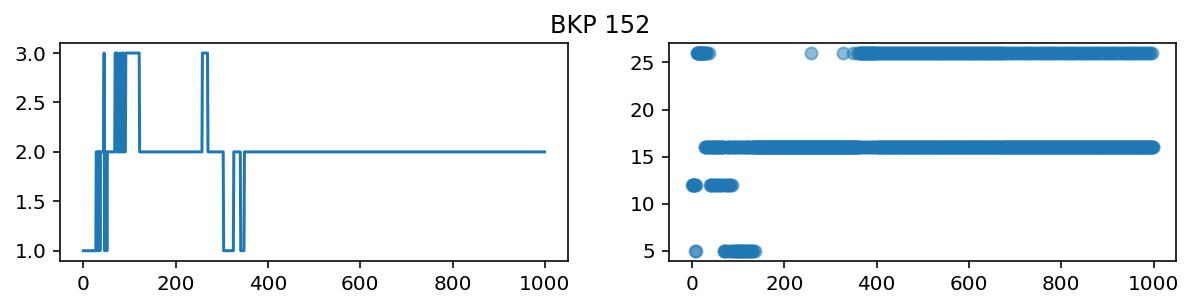

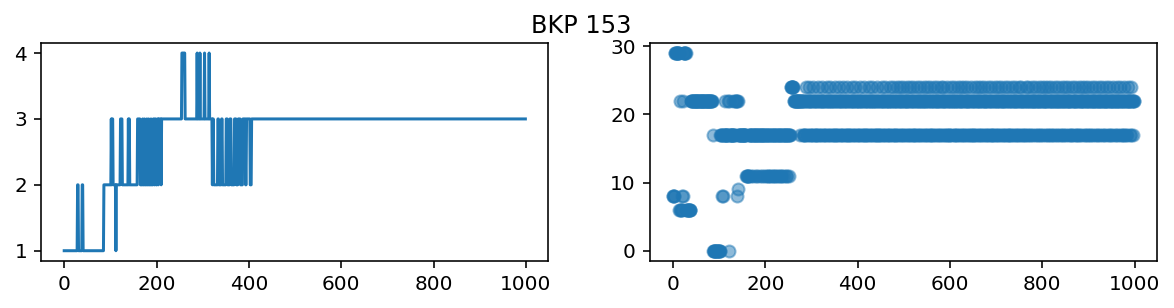

In [272]:
for i in range(150, 154):
    bkp = torch.load(f"checkpoints/2021-05-03T18-45-15/mario_net_{i}.chkpt")
    mario = Mario(state_dim=env.n_item*2, action_dim=env.action_space.n, save_dir=None)
    mario.net.load_state_dict(bkp['model'])
    mario.net.eval()
    env = Environment()
    state = env.reset()
    rewards = []
    actions = []
    while True:
        action_values = mario.net(state, model="online")
        action = torch.argmax(action_values).item()
        next_state, reward, done, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        if done:
            break
    fig, (ax1, ax2, ) = plt.subplots(ncols=2, figsize=(10, 2))
    fig.suptitle(f"BKP {i}")
    ax1.plot(rewards)
    ax2.scatter(np.arange(env.t_max), actions, alpha=0.5)
    plt.show()